# The CTRM data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)

## Looking at the CTRM files

We will start by looking at the CTRM geophone data we have for now

In [2]:
a = np.load("../ctrm/testData/LB_28ent.npy")
a.shape

(2558430, 5)

let's check that all coordinates are unique:

In [3]:
df = pd.DataFrame(a)
df.head()

,0,1,2,3,4
0,30.0,-40.0,20.0,151.0,0.001604
1,30.0,-40.0,20.0,152.0,0.001483
2,30.0,-40.0,20.0,153.0,0.001385
3,30.0,-40.0,20.0,154.0,0.001205
4,30.0,-40.0,20.0,155.0,0.001077


In [4]:
df.duplicated(subset=[0, 1, 2, 3]).sum()

0

it seems there are no duplicate coordinates in the cloud

The data is stored in a $(x, y, z, t, semblance)$ format, but we want it in $(t, z, x, y, semblance)$, so we will switch it:

In [5]:
a = a[:, [3, 2, 0, 1, 4]]
a[:, 0]

array([151., 152., 153., ..., 541., 542., 543.], dtype=float32)

let's choose a certain time, and also check that the data is distributed evenly:

In [6]:
b = a[a[:, 0] == 151.0]
a.shape[0] / b.shape[0]

393.0

$a$ now encode a box as $(t, z, x, y, semblance)$ coordinates

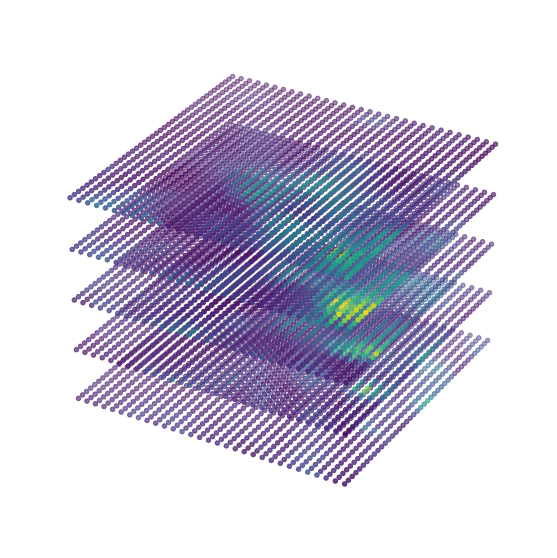

In [7]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.scatter(b[:, 2], b[:, 3], b[:, 1], c=b[:, 4])

plt.axis('off')
plt.show()

The data is stored as a cloud of voxels representation, but most machine learning models expect it to be organized in a matrix representation.

We will transform the data to a numpy array in the shape: $(i_{batch}, t, z, x, y)$ (we'll use the z, x, y representation because it's the representation used in the skimage library, and because it fits the large layer difference observed at the image above)

In [8]:
############## Turn cloud of voxels to matrix data ##################
def cloud_to_mat(cloud):
    """
    take a cloud of nD pixels, and transform it to a matrix representation
    for now we are assuming the cloud has now holes, but i plan to add support for a sparse 
    cloud later
    :param cloud: the cloud of pixel, where each row is a new pixel, such that all of the 
    values but the last one represent the location, and the last one is the value of the pixel
    :return: matrix, dmap where the matrix stores the data, and the map maps for each axis 
    its index value to its real world location
    """
    n_ax = cloud.shape[1] - 1
    ax_len = []
    dmap = []
    for col in cloud[:, :-1].T:
        cloud_vals = np.unique(col)
        dmap.append(cloud_vals)
        ax_len.append(len(cloud_vals))
    mat = np.zeros(ax_len, dtype=cloud.dtype)
    
    # map the cloud to the return matrix
    for row in cloud:
        idx = []
        for i, cord in enumerate(row[:-1]):
            aaa = np.where(dmap[i]==cord)
            idx.append(aaa[0][0])
            assert len(aaa) == 1, "more than 1 values found in the tuple"
            assert aaa[0].size == 1, "the array contains more than 1 value"
        mat[tuple(idx)] = row[-1]
    return mat, dmap


def read_dmap(data, dmap):
    """
    translate the coordiantes of a list of data to what is described in a dimentional map
    :param data: a list of data points in index space
    :param dmap: a map describing how to translate map space to index space
    :return: a list of data in map space
    """
    return NotImplementedError("read_dmap is not implemented yet")

In [9]:
mat, dmap = cloud_to_mat(a)
mat.shape, len(dmap), dmap[0][:5]

((393, 5, 31, 42), 4, array([151., 152., 153., 154., 155.], dtype=float32))

In [10]:
np.where(mat == 0)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

Let's compare the size of each frame before and after the transformation, because we ensured that there were no duplicated coordinates before the transformation, and that the number of points in each frame were the same, the following numbers should be the same:

In [11]:
assert b.shape[0] == mat[0].size, f"There were {b.shape[0]} coordinates in each frame \
before the transformation, now there are only {mat[0].size}"

In [12]:
mat.shape

(393, 5, 31, 42)

In [13]:
mat[0, 0, :5, :5]

array([[0.00160413, 0.00179073, 0.00261503, 0.0031899 , 0.00279279],
       [0.0015842 , 0.00179594, 0.00231361, 0.00250423, 0.00286429],
       [0.00148097, 0.00263516, 0.0026066 , 0.00265544, 0.00221018],
       [0.00250554, 0.00274844, 0.00222516, 0.00270331, 0.00185738],
       [0.00260413, 0.00284646, 0.00291623, 0.00241747, 0.00194738]],
      dtype=float32)

and let's check that we stored them correctly:

In [14]:
def flatten_matrix(mat, dmap=None, return_mode="lists"):
    """
    flatten a matrix by returning a value, index pair represantation
    :param mat: a numpy matrix to flatten
    :param dmap: a list, where each element maps a dimentional index to space coordinates.
    if None (default), use the indeces
    :param return_mode: {'lists', 'array'} how to return the output
    'lists' - (default) each dimention will return as a seperate list
    'tuples' - return a list of tuples, where each tuple is a voxel
    'array' - return a numpy array containing the coordinates
    :return: a value, coordinate pair
    """
    res = []
    for idx, x in np.ndenumerate(mat):
        if dmap is None:
            res.append(np.array([x] + list(idx)))
        else:
            raise NotImplementedError("the use of dmap is not implemented yet")
            
    if return_mode == 'lists':
        temp = np.array(res)
        res = []
        for col in temp.T:
            res.append(col)
        return res
    elif return_mode == 'tuples':
        return res
    elif return_mode == 'array':
        return np.array(res)
    else:
        raise NotImplementedError("the specified return method is not implemented")
        

def plot_a_3D_frame(mat, b, t, figsize=(10, 10), show_axis='off'):
    """
    plot a 3D frame from a batch file of 3D movies
    :param mat: the input matrix
    :param b: batch number. If there are no batches, pass None
    :param t: time index
    :param figsize: the size of the plot
    :param show_axis: 'on' or 'off', by default it is off
    :return: None
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')

    if b is None:
        data_cur = mat[t, :, :, :]
    else:
        data_cur = mat[b, t, :, :, :]
    c, iz, ix, iy = flatten_matrix(data_cur, return_mode='lists')
    ax.scatter(ix, iy, iz ,c=c)

    plt.axis(show_axis)
    plt.show()

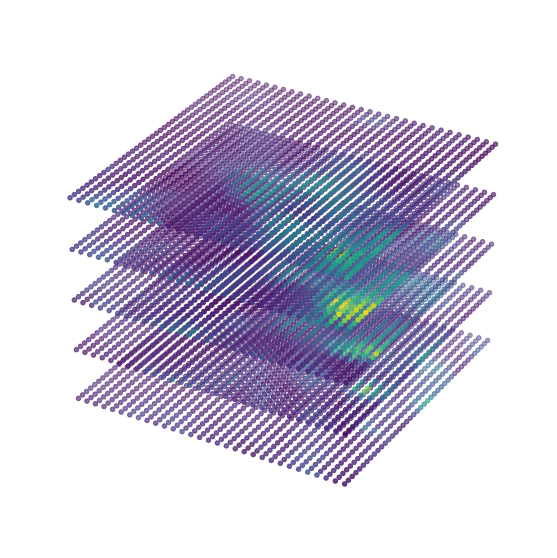

In [15]:
plot_a_3D_frame(mat, b=None, t=0)

The image is reconstructed perfectly, so we can assume that the algorithm runs smoothly

## Fabricated data

In case we don't have real, or synthetic data available, we can use the following code to generate fabricated data for basic testing (model input/ output layer fitting):

we ended up not needing it, so this section is commented out

In [16]:
# data_fab = np.random.normal(0, 1, size=(8, 100, 35, 70, 70))
# g = lambda x, x_max: (x - (0.5 * x_max)) ** 2
# f_mat = lambda b, t, z, x, y, zm, xm, ym : (b + 1) * (g(x, xm) + g(y, ym) + g(z, zm) + (t**2) + 1)

In [17]:
# xm = data_fab.shape[3]
# ym = data_fab.shape[4]
# zm = data_fab.shape[2]
# data_fab_noise = data_fab
# for ib in tqdm((range(data_fab.shape[0]))):
#     for it in range(data_fab.shape[1]):
#         for ix in range(xm):
#             for iy in range(ym):
#                 for iz in range(zm):
#                     data_fab[ib, it, iz, ix, iy] = f_mat(ib, it, iz, ix, iy, zm, xm, ym)
# data_fab = (data_fab / data_fab.max()) + (0.3 * data_fab_noise)
# del data_fab_noise

## Preprocessing

Before we can proceed with this input layer, we have to standardize the size of our data, since not all of our images match this input shape.

In [18]:
import cv2
import skimage
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

Let's have a look at a snapshot of one of our frames to have a feel at the data we fabricated

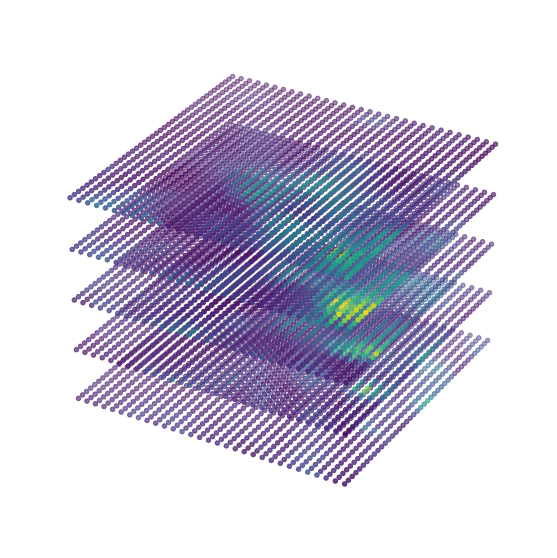

In [19]:
plot_a_3D_frame(mat, b=None, t=0)

We need to standardize the size of the frames so the network can expect exactly the same input size pass. We will fit all of our images to a standard size of $(x, y, z) = (4, 16, 16)$, but we will not touch the time dimension for now, since the time can remain variable, and we want to be able to predict on differing time scales.

We will define a function to resize the the image to any standard size:

In [20]:
from scipy.ndimage import zoom

def multD_resize(data, v_size, order=3, mode='constant'):
    """
    takes any numpy array, and zooms in or out as specified.
    can effect different dimensions differently.
    * we're using the zoom function from the scipy.ndimage library. It can be substituted 
    with the geometric_transform function from the same function, 
    :param data: the input, a numpy array
    :param v_size: a vector describing how to scale each of the of the dimensions. 
    - if a value for a dimension is a float, it will shrink or enlarge it by factoring by it 
    (for example, to double the number of pixels, pass 2.0f)
    - if a value for a dimension is an int, it will be the size of the new dimension
    - if a value of a dimention is None, it will remain as it is (same as passing 1)
    :param order: the order of the spline interpolation used to find the new data
    :param mode: {‘reflect’, ‘grid-mirror’, ‘constant’, ‘grid-constant’, ‘nearest’, ‘mirror’, 
    ‘grid-wrap’, ‘wrap’} 
    the method used to determine how to extend the new array beyond its original boundries.
    the default is 'constant'.
    :return: the resized data as a numpy array
    """
    v_fsize = v_size
    v_outp_s = list(data.shape)
    for i, s in enumerate(v_fsize):
        if s is None:
            # we want to ignore this dimension in our calculations
            v_fsize[i] = 1
        elif type(s) is int:
            # we want the new dimension to be of this size exactly
            v_outp_s[i] = s
            v_fsize[i] = s / data.shape[i]
        else:
            # we're assuming s is a float, 
            # and by passing a None, we're telling that we don't care about the exact new size
            v_outp_s[i] = None
    outp = zoom(data, v_fsize, order=order, mode=mode)
    
    for i, d in enumerate(v_outp_s):
        if d is not None:
            assert outp.shape[i] == d, f"the size of dim number {i+1} is {d}, expected {outp.shape[i]}"
    
    return outp

We will apply the transformation on our data:

In [21]:
x = multD_resize(mat, np.array([ None, 4, 16, 16]))
x.shape

(393, 4, 16, 16)

And let's check again how it look:

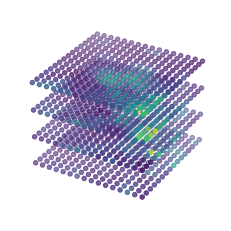

In [22]:
plot_a_3D_frame(x, None, 0, figsize=(4, 4))

Now that we have standardized the size of our frames, we will split them to train / val /test sets, and then we'll be able to proceed with the model

In [23]:
x = np.array(8 * [x])
print(x.shape)

y = np.zeros([x.shape[0], 1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=SEED)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

(8, 393, 4, 16, 16)


((4, 393, 4, 16, 16),
 (4, 1),
 (2, 393, 4, 16, 16),
 (2, 1),
 (2, 393, 4, 16, 16),
 (2, 1))

# The network

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv3D, Input, MaxPool3D, Flatten
from tensorflow.keras.layers import TimeDistributed, LSTM

## Constructing a test layer

We'll start by looking at  $4 \times 30^2$ one frame at a time. The first input dimension indicates time, the next 3 are for the frame sizes, and the last one is the color channel (only 1).

In [25]:
lay_input = Input(shape=(None, 4, 16, 16, 1))

We'll construct a prototype network with an input layer, 2 image processing layers (convolutional layers), and an LSTM layer to handle time.

This network will serve as a proof of concept to test how it handles 3D video input, and to see if convolutional RNN networks give us viable results.

After doing some testing with RNNs, we'll test time handling with transformers, and we'll compare the results.

## The spacial component

This will handle the input and the convolutionl layers

In [26]:
l_a = TimeDistributed(Conv3D(16, 2))(lay_input)
l_a = TimeDistributed(Conv3D(32, 2))(l_a)
l_a = TimeDistributed(MaxPool3D(2))(l_a)

In [27]:
model = tf.keras.Model(inputs= lay_input, outputs=l_a)

In [28]:
model.summary(line_length=100)

Model: "model"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         [(None, None, 4, 16, 16, 1)]            0              
____________________________________________________________________________________________________
time_distributed (TimeDistributed)           (None, None, 3, 15, 15, 16)             144            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)         (None, None, 2, 14, 14, 32)             4128           
____________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)         (None, None, 1, 7, 7, 32)               0              
Total params: 4,272
Trainable params: 4,272
Non-trainable params: 0
________

## The time component
connect the convolutional prototype to a time analysis layer (for now we'll test with LSTM, and in the future we will also test transformers)

In [29]:
l_b = TimeDistributed(Flatten())(l_a)
l_b = LSTM(1024)(l_b)
l_b = Dense(256)(l_b)
l_b = Dropout(0.5)(l_b)
l_b = Dense(3)(l_b)
model2 = tf.keras.Model(inputs= lay_input, outputs=l_b)

## Final model summary

In [30]:
model2.summary(line_length=100)

Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         [(None, None, 4, 16, 16, 1)]            0              
____________________________________________________________________________________________________
time_distributed (TimeDistributed)           (None, None, 3, 15, 15, 16)             144            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistributed)         (None, None, 2, 14, 14, 32)             4128           
____________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)         (None, None, 1, 7, 7, 32)               0              
__________________________________________________________________________

## Training on the fabricated data

In [31]:
model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [32]:
history = model2.fit(x=x_train, 
                     y=y_train, 
                     batch_size=2, 
                     epochs=4, 
                     validation_data=(x_val, y_val), 
                     shuffle=True, 
                     use_multiprocessing=True)

Epoch 1/4
2/2 [==============================] - 15s 7s/step - loss: 0.0020 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 2/4
2/2 [==============================] - 13s 7s/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - val_loss: 0.0292 - val_binary_accuracy: 1.0000
Epoch 3/4
2/2 [==============================] - 13s 7s/step - loss: 0.0079 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000
Epoch 4/4
2/2 [==============================] - 13s 7s/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_binary_accuracy: 1.0000


Text(0.5, 0, 'epoch')

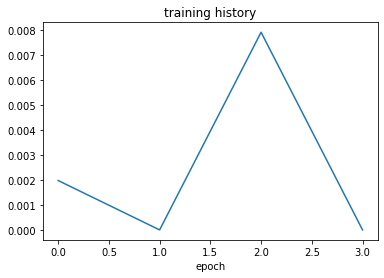

In [33]:
plt.plot(history.history['loss'])
plt.title("training history")
plt.xlabel("loss")
plt.xlabel("epoch")

In [34]:
model2.predict(x_test[:, :, :, :, :])

array([[ -5.2111025, -11.129934 ,  -9.036389 ],
       [ -5.2111025, -11.129934 ,  -9.036389 ]], dtype=float32)

## Sequence to sequence model

We want to be able to detect a changing source, under the assumption that at each time there is at most one source. We'll modify the network above to output a sequence

### reformatting the data

we will change the data from one long sequence of frames, to snippets of 100 frames

In [35]:
def spread_data(seq, s, pad=0, do_pad=True):
    """
    take a sequence of data (first index is the time index), and cut it into snapshots of 
    predetermined size
    :param seq: the sequence of data, should be accessible with seq[t] 
    :param s: the size of each chunk in the sequence
    :param pad: data used to pad when the sequence just begins
    :param do_pad: bool, if false, will not create padded sequences
    :return: a list of snapshots from the sequence
    """
    res = []
    T = len(seq)
    if do_pad:
        t0 = 0
    else:
        t0 = s - 1
    for t in range(t0-s+1, T-s+1):
        a = []
        tf = t+s
        if t < 0:
            a.extend([pad] * (-t))
            t = 0
        a.extend(seq[t:tf])
        res.append(a)
    return res

In [37]:
xt = spread_data(x[0], 100, pad=np.zeros_like(x[0][0]))
ytp = [np.ones((1, ))] * len(xt)
ytb = [np.ones((6, )) * 0.5] * len(xt)
yt = [ytp, ytb]

lt = len(xt)
t1 = int(0.6 * lt)
t2 = int(0.8 * lt)

xt_train = np.array(xt[:t1])
yt_train = [np.array(ytp[:t1]), np.array(ytb[:t1])]

xt_val = np.array(xt[t1:t2])
yt_val = [np.array(ytp[t1:t2]), np.array(ytb[t1:t2])]

xt_test = np.array(xt[t2:])
yt_test = [np.array(ytp[t2:]), np.array(ytb[t2:])]

xt_train.shape, yt_train[0].shape, yt_train[1].shape, \
xt_val.shape, yt_val[0].shape, yt_val[1].shape, \
xt_test.shape, yt_test[0].shape, yt_test[1].shape

((235, 100, 4, 16, 16),
 (235, 1),
 (235, 6),
 (79, 100, 4, 16, 16),
 (79, 1),
 (79, 6),
 (79, 100, 4, 16, 16),
 (79, 1),
 (79, 6))

In [39]:
################### Input layer ###################
lay_input2 = Input(shape=(100, 4, 16, 16, 1))

################### Space layer ###################
l_c = TimeDistributed(Conv3D(16, 2))(lay_input2)
l_c = TimeDistributed(Conv3D(32, 2))(l_c)
l_c = TimeDistributed(MaxPool3D(2))(l_c)

################### Time layer ###################
l_c = TimeDistributed(Flatten())(l_c)
l_c = LSTM(1024)(l_c)
l_c = Dense(256)(l_c)
l_c = Dropout(0.5)(l_c)

l_c1 = Dense(1, activation="sigmoid", name="proba")(l_c)
l_c2 = Dense(6, activation="tanh", name="bbox")(l_c)
model3 = tf.keras.Model(inputs= lay_input2, outputs=[l_c1, l_c2], name="seq2seq_model")

model3.summary(line_length=100)

Model: "seq2seq_model"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             [(None, 100, 4, 16, 1 0                                            
____________________________________________________________________________________________________
time_distributed_8 (TimeDistribu (None, 100, 3, 15, 15 144         input_3[0][0]                    
____________________________________________________________________________________________________
time_distributed_9 (TimeDistribu (None, 100, 2, 14, 14 4128        time_distributed_8[0][0]         
____________________________________________________________________________________________________
time_distributed_10 (TimeDistrib (None, 100, 1, 7, 7,  0           time_distributed_9[0][0]         
____________________________________________________________________

In [40]:
model3.compile(optimizer='adam', 
              loss={
                  "proba": 'binary_crossentropy',
                  "bbox": 'mse'
              }, 
              metrics={
                  "proba": 'binary_crossentropy',
                  "bbox": 'mse'
              })

In [41]:
history3 = model3.fit(x=xt_train, 
                      y=yt_train, 
                      batch_size=4, 
                      epochs=4, 
                      validation_data=(xt_val, yt_val), 
                      shuffle=False, 
                      use_multiprocessing=True)

Epoch 1/4
59/59 [==============================] - 107s 2s/step - loss: 0.2773 - proba_loss: 0.0282 - bbox_loss: 0.2491 - proba_binary_crossentropy: 0.0282 - bbox_mse: 0.2491 - val_loss: 0.2500 - val_proba_loss: 6.7615e-16 - val_bbox_loss: 0.2500 - val_proba_binary_crossentropy: 6.7615e-16 - val_bbox_mse: 0.2500
Epoch 2/4
59/59 [==============================] - 105s 2s/step - loss: 0.2500 - proba_loss: 3.0561e-06 - bbox_loss: 0.2500 - proba_binary_crossentropy: 3.0561e-06 - bbox_mse: 0.2500 - val_loss: 0.2500 - val_proba_loss: 2.4738e-16 - val_bbox_loss: 0.2500 - val_proba_binary_crossentropy: 2.4738e-16 - val_bbox_mse: 0.2500
Epoch 3/4
59/59 [==============================] - 107s 2s/step - loss: 0.2499 - proba_loss: 8.5207e-09 - bbox_loss: 0.2499 - proba_binary_crossentropy: 8.5207e-09 - bbox_mse: 0.2499 - val_loss: 0.2500 - val_proba_loss: 1.7004e-16 - val_bbox_loss: 0.2500 - val_proba_binary_crossentropy: 1.7004e-16 - val_bbox_mse: 0.2500
Epoch 4/4
59/59 [=========================

Text(0.5, 0, 'epoch')

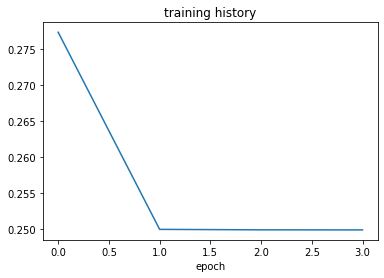

In [42]:
plt.plot(history3.history['loss'])
plt.title("training history")
plt.xlabel("loss")
plt.xlabel("epoch")

In [43]:
model3.predict(xt_test[:1, :, :, :, :])

[array([[1.]], dtype=float32),
 array([[1., 1., 1., 1., 1., 1.]], dtype=float32)]

# Conclusions

The model compiled and trained successfully. Based on this, we should probably proceed with fully implementing a convLSTM network: 

 - we need to generate a large dataset to actually train a model on (synthetic, or authentic if possible).
 - we need to discuss different ways to encode the target variable of the network, and settle on the one that fits our business needs best.
 - we need to tune the network on different hyperparameters and architectures to find the best ones.
 - we need to look for ways to improve our data generation and augmentation methods
 - after creating a good model, we should look into other architecture types, and compare the results